In [1]:
import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import joblib

import carpyncho

from libs.container import Container
from libs.nearest import nearest
import dataset

## Read the catalogs and scale the

In [9]:
%%time

fname = "results/clf/cats.pkl"
if os.path.exists(fname):
    results = joblib.load(fname)
    results = {
        k: (Container(v) if isinstance(v, dict) else v)
        for k, v in results.items()}
    locals().update(results)
else:    
    cats = dataset.load_catalogs("b277", "b261", "b278", "b360")
    
    # sampling
    sample = joblib.load("dataset/sample.pkl")
    for tname, tile in list(cats.items()):
        cats[tname] = tile[tile.id.isin(sample)].copy()    

    ## Scaling
    scl = StandardScaler()
    all_df = pd.concat(cats.values())
    
    all_df[dataset.FEATURES] = scl.fit_transform(all_df[dataset.FEATURES].values)
    
    # eliminamos lo que da nan o inf en lo normalizado
    for x in all_df.columns:
        if all_df[x].dtype == object:
            continue
        if np.isnan(all_df[x].values).sum():
            all_df = all_df[~np.isnan(all_df[x].values)]
        if np.isinf(all_df[x].values).sum():
            all_df = all_df[~np.isinf(all_df[x].values)]
    
    # removemos de los catalogos lo que estuvo en inf en lo normalizado
    for tname, tile in cats.items():
        tile = tile[tile.id.isin(all_df.id)].copy()
    
    # split
    scats = Container({
        gn: gdf.copy() for gn, gdf in all_df.groupby("tile")})
    
    results = {"scl": scl, "cats": dict(cats), "scats": dict(scats)}
    joblib.dump(results, fname, compress=3)
    
    del all_df
    
del results

CPU times: user 3.6 s, sys: 154 ms, total: 3.76 s
Wall time: 3.78 s


## Features

In [10]:
X_columns = np.array(dataset.FEATURES)
X_columns

array(['Amplitude', 'Autocor_length', 'Beyond1Std', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3',
       'Gskew', 'LinearTrend', 'MaxSlope', 'Mean',

In [11]:
sX_columns = np.array(list(joblib.load("results/rfe_features.pkl.bz2")))
sX_columns

array(['Amplitude', 'Autocor_length', 'Eta_e', 'FluxPercentileRatioMid50',
       'FluxPercentileRatioMid65', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'LinearTrend', 'Mean', 'MedianBRP', 'PercentAmplitude',
       'PercentDifferenceFluxPercentile', 'Psi_eta', 'Q31', 'Rcs', 'Std',
       'c89_hk_color', 'c89_jh_color', 'c89_jk_color', 'c89_m2', 'c89_m4',
       'n09_c3', 'n09_hk_color', 'n09_jh_color', 'n09_jk_color', 'n09_m2',
       'n09_m4'], dtype='<U31')

In [12]:
uX_columns = np.array([c for c in X_columns if c not in sX_columns])
uX_columns

array(['Beyond1Std', 'Con', 'FluxPercentileRatioMid20',
       'FluxPercentileRatioMid35', 'FluxPercentileRatioMid80',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3',
       'Gskew', 'MaxSlope', 'MedianAbsDev', 'PairSlopeTrend', 'PeriodLS',
       'Period_fit', 'Psi_CS', 'Skew', 'SmallKurtosis', 'c89_c3', 'ppmb'],
      dtype='<U27')

## Hiper parameters selection

In [13]:
# copiamos hiper parametros del paper anterior
RF_PARAMS = {
    'criterion': 'entropy', 
    'max_features': 'log2', 
    'min_samples_split': 2, 
    'n_estimators': 500, 
    'n_jobs': 20}

In [14]:
def make_clf(k, df, X_columns):    
    X_train = df[X_columns].values
    y_train = df.cls.values

    clf = RandomForestClassifier(**RF_PARAMS)
    clf.fit(X_train, y_train)
    return k, clf


def get_clfs(data, X_columns):
    print("Creating classifiers with {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=-1) as jobs:
        clfs = jobs(
            joblib.delayed(make_clf)(k, d, X_columns)
            for k, d in sorted(tqdm.tqdm(data.items())))
    return Container(clfs)


def get_combs(data, X_columns):
    combs = []
    clfs = get_clfs(data, X_columns)
    for train_name, clf in clfs.items():
        for test_name in clfs.keys():
            if train_name != test_name:
                test_sample = data[test_name]
                comb = Container({
                    "idx": len(combs), 
                    "train_name": train_name, "clf": clf,  
                    "test_name": test_name, "test_sample": test_sample,
                    "X_columns": X_columns, "y_column": "cls"})
                combs.append(comb)
    return combs


def execute_clf(idx, train_name, clf, test_name, test_sample, X_columns, y_column):
    
    X_test = test_sample[X_columns].values
    y_test = test_sample[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    result = {
        "idx": idx,
        "train_name": train_name,
        "test_name": test_name,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        "precision_score": metrics.precision_score(y_test, predictions),
        "recall_score": metrics.recall_score(y_test, predictions),
        'real_cls': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)}   
    return result

def train_and_run(data, X_columns, fname):
    if os.path.exists(fname):
        results = joblib.load(fname)
        
    else:
        combs = get_combs(data, X_columns)
        print("Combinaciones: {}".format(len(combs)))

        print("Launching classifiers for {} features...".format(len(X_columns)))
        with joblib.Parallel(n_jobs=-1) as jobs:
            results = jobs(
                joblib.delayed(execute_clf)(**comb) for comb in tqdm.tqdm(combs))

        joblib.dump(results , fname, compress=3)
        
    return [Container(e) for e in results]


In [15]:
%%time
afeats_results = train_and_run(scats, X_columns, "results/clf/afeats_results.pkl")

CPU times: user 78.2 ms, sys: 0 ns, total: 78.2 ms
Wall time: 77.6 ms


In [16]:
%%time
selected_results = train_and_run(scats, sX_columns, "results/clf/rfe_results.pkl")

CPU times: user 82.9 ms, sys: 0 ns, total: 82.9 ms
Wall time: 81.3 ms


In [17]:
%%time
unselected_results = train_and_run(scats, uX_columns, "results/clf/not_rfe_results.pkl")

CPU times: user 84.8 ms, sys: 0 ns, total: 84.8 ms
Wall time: 83.9 ms


In [18]:
def roc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()

    for res in results:
        cname = "{} Vs. {}".format(res.train_name, res.test_name)
        label = cname if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()
        
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

ax = axes[0]
roc(afeats_results, ax=ax[0])
prc(afeats_results, ax=ax[1], labels=False)
ax[0].set_ylabel("All Features\n" + ax[0].get_ylabel())

ax = axes[1]
roc(selected_results, ax=ax[0], labels=False)
prc(selected_results, ax=ax[1], labels=False)
ax[0].set_ylabel("RFE\n" + ax[0].get_ylabel())

ax = axes[2]
roc(unselected_results, ax=ax[0], labels=False)
prc(unselected_results, ax=ax[1], labels=False)
ax[0].set_ylabel("Not-RFE\n" + ax[0].get_ylabel())

lgd = fig.legend()
fig.tight_layout();

plt.close()

In [19]:
POSITIONS = {
    "b206": (13, 8),
    "b214": (13, 0),
    "b216": (12, 12),
    'b220': (12, 8),
    "b228": (12, 0),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    "b360": (2, 8),
    'b396': ( 0, 0),
}

tiles = list(sorted(scats.keys()))
tiles

['b261', 'b277', 'b278', 'b360']

In [20]:
FR = .6

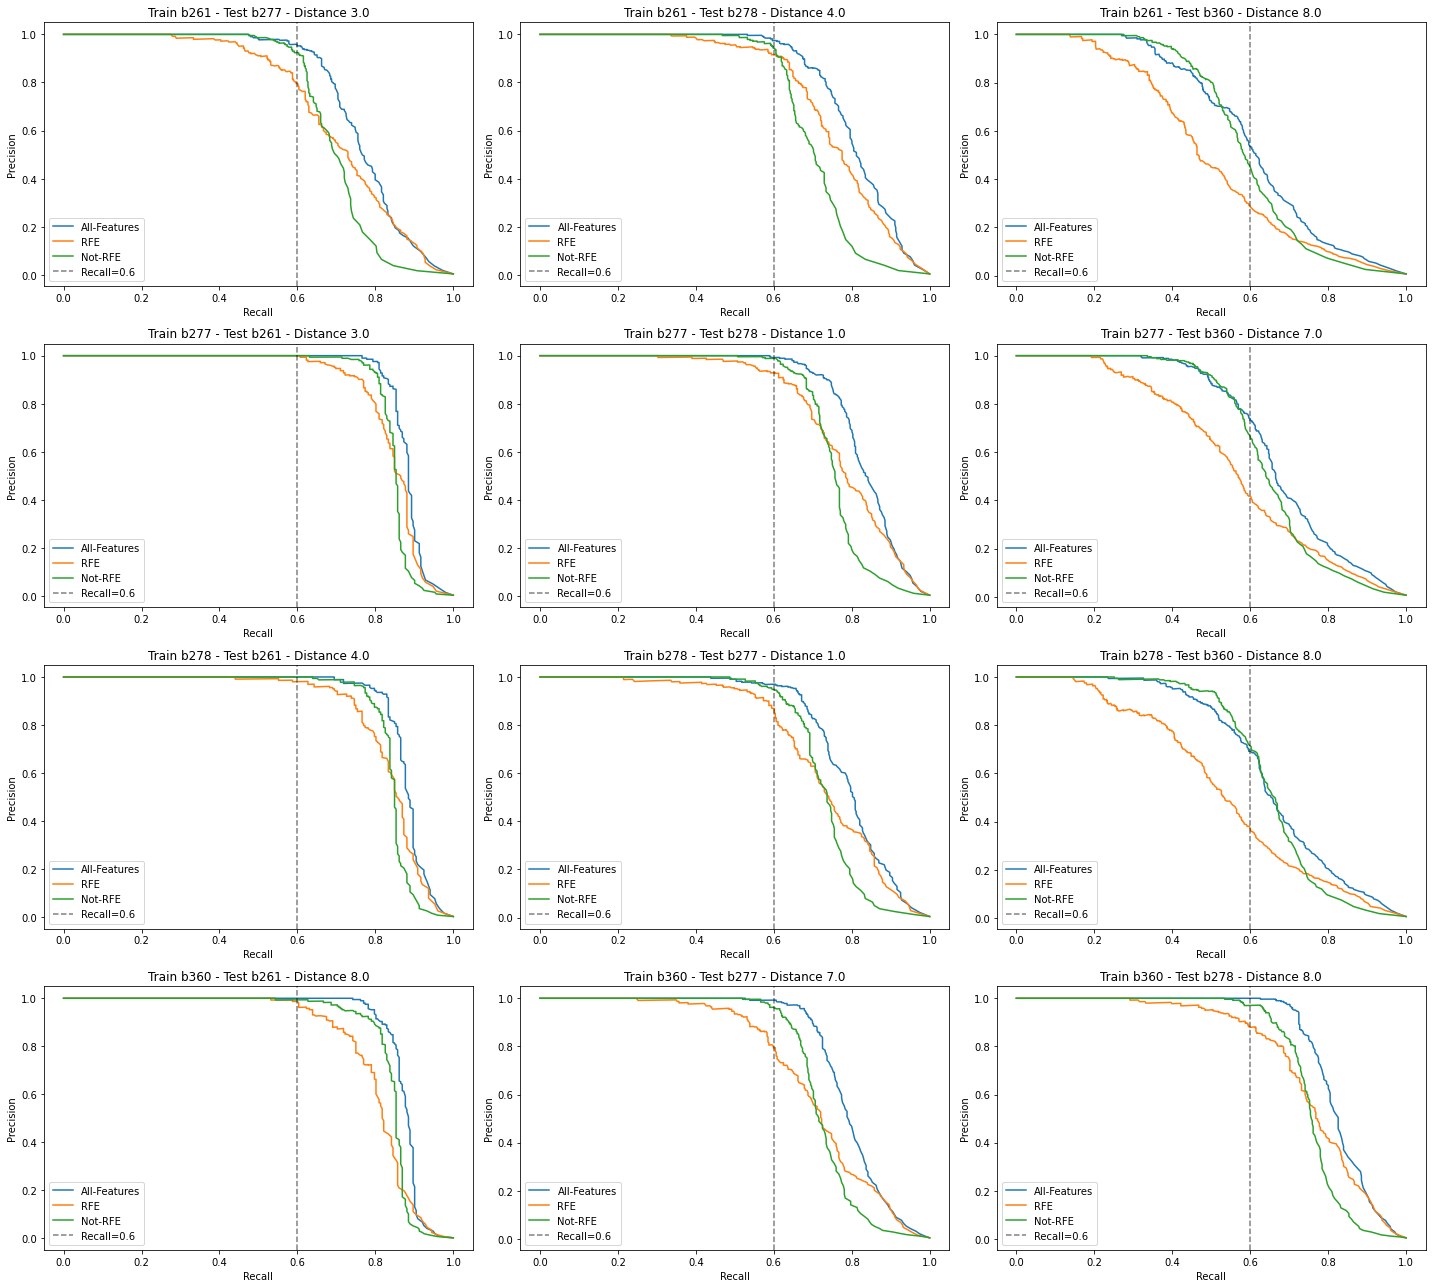

In [21]:
import itertools as it 
from scipy.spatial import distance

all_results = {
    "All-Features": afeats_results,
    "RFE": selected_results,
    "Not-RFE": unselected_results
}

def get_distance(ta, tb):
    pa = list(map(float, POSITIONS[ta]))
    pb = list(map(float, POSITIONS[tb]))
    return distance.cityblock(pa, pb)


def plot_prec_roc_curve(ax, train_name, test_name, distance, all_results):
    for rname, results in all_results.items():
        for r in results:
            if r.test_name == test_name and r.train_name == train_name:
                ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=rname)
                break
    ax.set_title("Train {} - Test {} - Distance {}".format(train_name, test_name, distance))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")


combs = []
for train_name in tiles:
    for test_name in tiles:
        if train_name == test_name:
            continue
        dis = get_distance(train_name, test_name)
        combs.append((train_name, test_name, dis))

fig, axes = plt.subplots(4, 3, figsize=(20, 18))
axes = list(it.chain(*axes))
ax_comb = zip(axes, combs)

for axs, train_test in ax_comb:
    train_name, test_name, distance = train_test
    ee = plot_prec_roc_curve(axs, train_name, test_name, distance, all_results)
    axs.axvline(FR, alpha=.5, color="k", ls="--", label=f"Recall={FR}")
    axs.legend(loc='lower left')


fig.tight_layout()
plt.savefig("plots/tiles_curves.pdf")

## By test

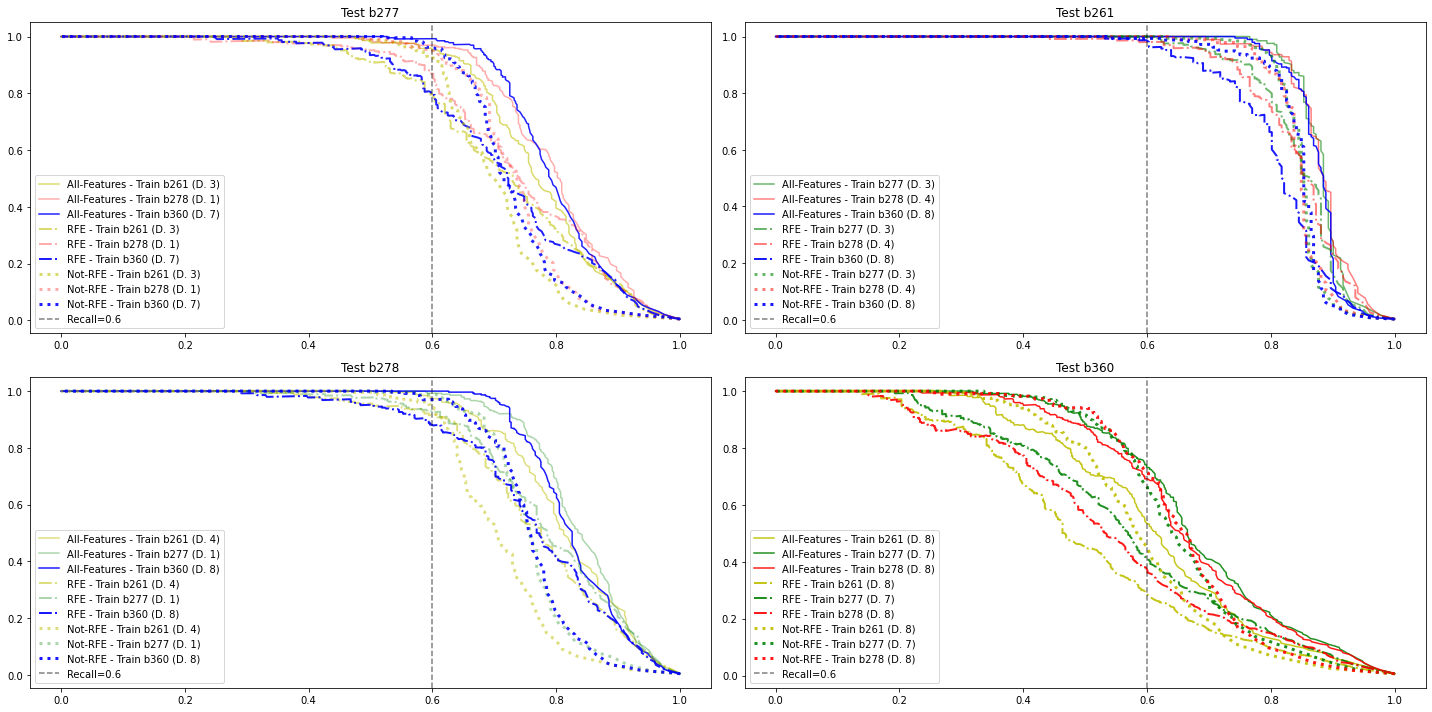

In [85]:
import itertools as it 
from scipy.spatial import distance
from matplotlib import cm

all_results = {
    "All-Features": afeats_results,
    "RFE": selected_results,
    "Not-RFE": unselected_results
}

tiles = list(cats.keys())


colors = {
    "b278": "r",
    "b360": "b",
    "b277": "g",
    "b261": "y",
}

def get_distance(ta, tb):
    pa = list(map(float, POSITIONS[ta]))
    pb = list(map(float, POSITIONS[tb]))
    return distance.cityblock(pa, pb)


def plot_prec_roc_curve_single(ax, test_name, fs, results, **kwargs):
    for r in results:
        if r.test_name == test_name:
            distance = int(get_distance(test_name, r.train_name))
            kwargs["color"] = colors[r.train_name]
            label = f"{fs} - Train {r.train_name} (D. {distance})"
            alpha = (distance / 8.)
            if alpha < .5:
                alpha += .2
            if alpha == 1:
                alpha=.9
            ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label, alpha=alpha, **kwargs)
    

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

test_axes = zip(tiles, it.chain(*axes))
for test, ax in test_axes:
    plot_prec_roc_curve_single(ax, test, "All-Features", afeats_results, ls="-")
    plot_prec_roc_curve_single(ax, test, "RFE", selected_results, ls="-.", linewidth=2)
    plot_prec_roc_curve_single(ax, test, "Not-RFE", unselected_results, ls=":", linewidth=3)
    
    ax.set_ylabel("Recall")
    ax.set_xlabel("Precision")
    
    ax.axvline(FR, alpha=.5, color="k", ls="--", label=f"Recall={FR}")
    ax.legend(loc='lower left')
    ax.set_title("Test {}".format(test))
# axes[0].set_ylabel(f"All-Features\nPecision")




fig.tight_layout()

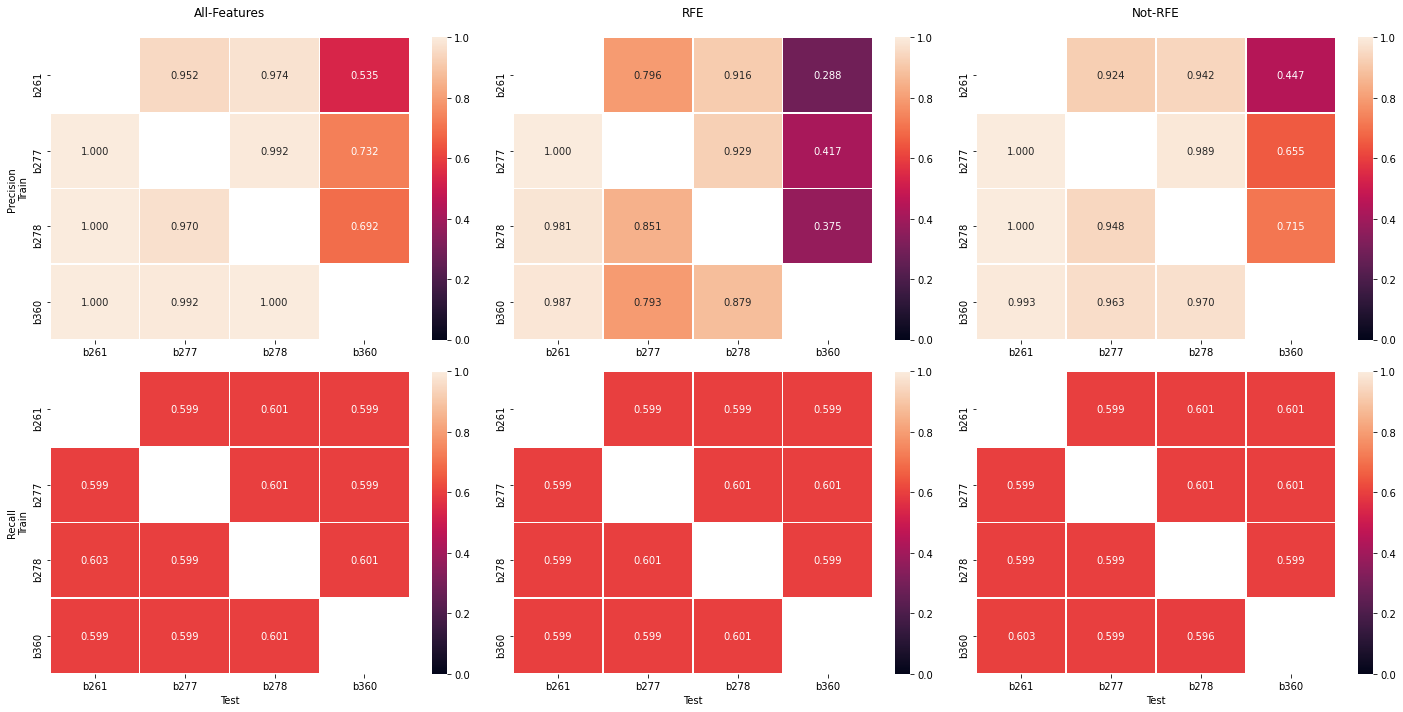

In [23]:
def as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Train": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Train")[tiles]
    return df


def heatmap(axs, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        
    fix_precs = as_df(fix_precs)
    fix_recall = as_df(fix_recall)
    
    ax = axs[0]
    sns.heatmap(
        fix_precs, annot=True, fmt='.3f',  
        linewidths=.5, ax=ax, cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax.set_ylabel("")
    
    ax = axs[1]
    sns.heatmap(
        fix_recall, annot=True, fmt='.3f',  
        linewidths=.5, ax=ax, cmap=cmap, center=.5, vmin=0., vmax=1.)
    
    ax.set_ylabel("")
    ax.set_xlabel("Test")
    

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.T

for rn, axs in zip(all_results, axes):
    results = all_results[rn]
    heatmap(axs, results, FR)
    
    axs[0].set_title(f"{rn}\n{axs[0].get_title()}")
    
axes[0][0].set_ylabel(f"Precision\nTrain")
axes[0][1].set_ylabel(f"Recall\nTrain")


fig.tight_layout()
fig.savefig("plots/tiles_heatmap.pdf")